In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
DATA_DIR = '/groups/hep/mojen/repositories/DREAM/Run/final_run/tauolaevts/10000'
# DATA_DIR = '/home/jupyter/DREAM'
df = pd.read_csv(os.path.join(DATA_DIR, 'data.csv'))
print(df.shape)
df.head()

(15874, 13)


,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,dist2charge,label
0,0,0,4,21408.335401,11140.1160,4807.88870,10.362349,6.491467,0.025355,0.044280,0.431583,0.000000,3
1,0,1,4,924.508020,NaN,1073.34800,NaN,1.968934,NaN,0.157025,NaN,16.782349,2
2,0,2,4,1100.245997,783.3830,904.80566,1.832438,1.448789,0.197458,0.176471,1.154998,128.826170,2
3,0,3,4,1643.766190,1418.5334,1472.52690,1.834256,1.933337,0.262542,0.180723,1.038063,69.048379,2
4,0,4,4,10000.615035,8540.6990,9518.20100,2.460657,1.579473,0.173625,0.339236,1.114452,56.487324,2


In [3]:
cal = np.load("calibration.pkl.npy", allow_pickle=True).item()

In [4]:
df['rec_energy'] = df.apply(lambda x: (x.S_sum-cal['chi']*x.C_sum)/(1-cal['chi']), axis=1)

In [5]:
df.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,dist2charge,label,rec_energy
0,0,0,4,21408.335401,11140.1160,4807.88870,10.362349,6.491467,0.025355,0.044280,0.431583,0.000000,3,13573.675275
1,0,1,4,924.508020,NaN,1073.34800,NaN,1.968934,NaN,0.157025,NaN,16.782349,2,NaN
2,0,2,4,1100.245997,783.3830,904.80566,1.832438,1.448789,0.197458,0.176471,1.154998,128.826170,2,736.718655
3,0,3,4,1643.766190,1418.5334,1472.52690,1.834256,1.933337,0.262542,0.180723,1.038063,69.048379,2,1397.782979
4,0,4,4,10000.615035,8540.6990,9518.20100,2.460657,1.579473,0.173625,0.339236,1.114452,56.487324,2,8165.031964


In [97]:
# train test split by eventId!
id_train, id_test = train_test_split(df.eventId.values,
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify=df.PrimaryDecayMode.values)
print(id_train.shape, id_test.shape)

(11111,) (4763,)


In [98]:
excl_columns = ['eventId', 'PrimaryDecayMode', 'clusterId', 'VecShowerEnergy', 'label']

# train dataset
df_train = df[df.eventId.isin(id_train)].copy()
df_train.to_csv(os.path.join(DATA_DIR, 'dftrain.csv'), index=False)
# df_train.drop(['eventId'], inplace=True, axis=1)
y_train = df_train.label.values
z_train = df_train.VecShowerEnergy.values
df_train.drop(excl_columns, inplace=True, axis=1)
X_train = df_train.values
train_data_y = lgb.Dataset(X_train, label=y_train, feature_name=list(df_train.columns.values))
train_data_z = lgb.Dataset(X_train, label=z_train, feature_name=list(df_train.columns.values))

# test data set
df_test = df[df.eventId.isin(id_test)].copy() #.drop(['eventId'], axis=1)
y_test = df_test.label.values
z_test = df_test.VecShowerEnergy.values
# id_test = df_test.clusterId.values.reshape([-1,1])
df_test.drop(excl_columns, inplace=True, axis=1)
X_test = df_test.values
test_data_y = lgb.Dataset(X_test, label=y_test, feature_name=list(df_test.columns.values))
test_data_z = lgb.Dataset(X_test, label=z_test, feature_name=list(df_test.columns.values))

In [99]:
print(df_train.shape, df_test.shape, id_test.shape)

(14206, 9) (9428, 9) (4763,)


In [100]:
X_train

array([[1.11401160e+04, 4.80788870e+03, 1.03623490e+01, ...,
        4.31583361e-01, 0.00000000e+00, 1.35736753e+04],
       [           nan, 1.07334800e+03,            nan, ...,
                   nan, 1.67823493e+01,            nan],
       [7.83383000e+02, 9.04805660e+02, 1.83243810e+00, ...,
        1.15499782e+00, 1.28826170e+02, 7.36718655e+02],
       ...,
       [1.11045250e+03, 8.78193300e+02, 1.80241980e+00, ...,
        7.90842742e-01, 9.85351674e+01, 1.19971280e+03],
       [7.93858400e+03, 8.02792800e+03, 2.25928330e+00, ...,
        1.01125440e+00, 4.99594356e+01, 7.90424791e+03],
       [5.85459030e+03, 5.93445800e+03, 2.36258100e+00, ...,
        1.01364189e+00, 6.42443818e+01, 5.82389608e+03]])

# Classification

(Boosted) decision trees 'unaffected' by feature scaling

### Training

In [23]:
params = {
    'num_class': [4],
    'objective': ['multiclass'],# 'multiclassova'],
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1],  # default = 0.1
    'num_leaves': [31],  # default = 31
    'metric': ['multi_logloss']
}

In [24]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]
param

[{'num_class': 4,
  'objective': 'multiclass',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 31,
  'metric': 'multi_logloss'}]

In [25]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_y, num_boost_round=500, early_stopping_rounds=20, verbose_eval=True, seed=42)
    results += [(i, len(cv_results['multi_logloss-mean']), cv_results['multi_logloss-mean'][-1])]

[1]	cv_agg's multi_logloss: 0.852804 + 0.00108269
[2]	cv_agg's multi_logloss: 0.744393 + 0.00131236
[3]	cv_agg's multi_logloss: 0.660054 + 0.00177576
[4]	cv_agg's multi_logloss: 0.591236 + 0.00211434
[5]	cv_agg's multi_logloss: 0.533574 + 0.00232795
[6]	cv_agg's multi_logloss: 0.484606 + 0.00256774
[7]	cv_agg's multi_logloss: 0.442265 + 0.00299095
[8]	cv_agg's multi_logloss: 0.405369 + 0.00323708
[9]	cv_agg's multi_logloss: 0.373344 + 0.00344084
[10]	cv_agg's multi_logloss: 0.345043 + 0.00359238
[11]	cv_agg's multi_logloss: 0.320115 + 0.00384491
[12]	cv_agg's multi_logloss: 0.298008 + 0.00394158
[13]	cv_agg's multi_logloss: 0.278378 + 0.00396943
[14]	cv_agg's multi_logloss: 0.260869 + 0.0040961
[15]	cv_agg's multi_logloss: 0.245173 + 0.00408218
[16]	cv_agg's multi_logloss: 0.231108 + 0.00418743
[17]	cv_agg's multi_logloss: 0.218461 + 0.00425554
[18]	cv_agg's multi_logloss: 0.20716 + 0.00444765
[19]	cv_agg's multi_logloss: 0.197074 + 0.00449837
[20]	cv_agg's multi_logloss: 0.187977 + 0.

In [26]:
results.sort(key=lambda x: x[2])
results

[(0, 64, 0.10570708897887733)]

In [27]:
bst = lgb.train(param[results[0][0]], train_data_y, num_boost_round=results[0][1])

### Testing

In [84]:
X_test.shape[0] / 2

4714.0

In [28]:
y_pred = np.argmax(bst.predict(X_test), axis=1).reshape([-1,1])

In [29]:
confusion_matrix(y_test, y_pred)

array([[ 542,    5,    0,    8],
       [   6,  292,    0,   88],
       [   0,    0, 6606,    0],
       [  28,  106,    0, 1747]])

In [30]:
accuracy_score(y_test, y_pred)

0.9744378447178617

In [31]:
df_new = pd.DataFrame(np.hstack((id_test, y_pred)), columns=['clusterId', 'predictedLabel'])
df_merged = df.merge(df_new, how='inner', on='clusterId')
df_merged.head()

,eventId,clusterId,PrimaryDecayMode,VecShowerEnergy,S_sum,C_sum,S_rad_mean,C_rad_mean,S_hot,C_hot,CoverS,dist2charge,label,rec_energy,predictedLabel
0,0,0,4,21408.335401,11140.1160,4807.88870,10.362349,6.491467,0.025355,0.044280,0.431583,0.000000,3,13573.675275,3
1,0,1,4,924.508020,NaN,1073.34800,NaN,1.968934,NaN,0.157025,NaN,16.782349,2,NaN,2
2,0,2,4,1100.245997,783.3830,904.80566,1.832438,1.448789,0.197458,0.176471,1.154998,128.826170,2,736.718655,2
3,0,3,4,1643.766190,1418.5334,1472.52690,1.834256,1.933337,0.262542,0.180723,1.038063,69.048379,2,1397.782979,2
4,0,4,4,10000.615035,8540.6990,9518.20100,2.460657,1.579473,0.173625,0.339236,1.114452,56.487324,2,8165.031964,2


In [79]:
df_merged.shape

(9428, 16)

In [111]:
df_merged.predictedLabel.isna().sum()

0

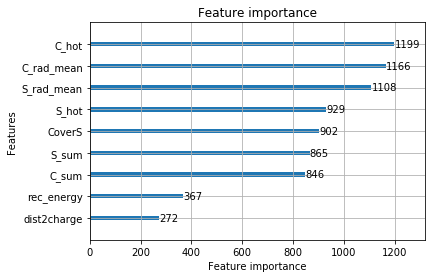

In [32]:
lgb.plot_importance(bst)

In [33]:
param[results[0][0]]

{'num_class': 4,
 'objective': 'multiclass',
 'boosting': 'gbrt',
 'learning_rate': 0.1,
 'num_leaves': 31,
 'metric': 'multi_logloss'}

In [34]:
from sklearn.inspection import permutation_importance
model = lgb.LGBMClassifier(**param[results[0][0]], n_estimators=results[0][1])
model = model.fit(X_train, y_train)
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{train_data_y.feature_name[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

ImportError: cannot import name 'permutation_importance'

ImportError: cannot import name 'Digraph'

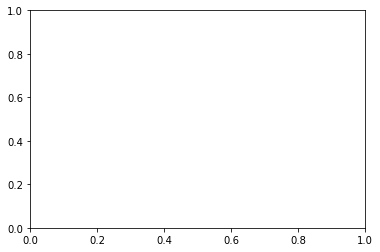

In [35]:
lgb.plot_tree(bst)

## Regression

### Training

In [19]:
params = {
    'objective': ['regression'],
    'boosting': ['gbrt'],  # default = gbdt
    'learning_rate': [0.1, 0.01],  # default = 0.1
    'num_leaves': [31],  # default = 31
    'metric': ['mape', 'rmse']
}

In [20]:
import itertools
keys, values = zip(*params.items())
param = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [21]:
param

[{'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 31,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.1,
  'num_leaves': 31,
  'metric': 'rmse'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.01,
  'num_leaves': 31,
  'metric': 'mape'},
 {'objective': 'regression',
  'boosting': 'gbrt',
  'learning_rate': 0.01,
  'num_leaves': 31,
  'metric': 'rmse'}]

In [22]:
results = []
for i in range(len(param)):
    cv_results = lgb.cv(param[i], train_data_z, num_boost_round=500, early_stopping_rounds=20, verbose_eval=True, seed=42, stratified=False)
    print(cv_results)
    metric_name = param[i]['metric']+"-mean"
    results += [(i, len(cv_results[metric_name]), cv_results[metric_name][-1])]

[1]	cv_agg's mape: 1.89429 + 0.059043
[2]	cv_agg's mape: 1.72524 + 0.0523248


KeyboardInterrupt: 

In [11]:
results.sort(key=lambda x: x[2])
results

[(0, 77, 0.22797080101867281),
 (2, 500, 0.2340436112965984),
 (3, 498, 4381.62465775851),
 (1, 50, 4396.770246919716)]

In [12]:
bst = lgb.train(param[results[0][0]], train_data_z, num_boost_round=results[0][1])

[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data: 14206, number of used features: 8
[LightGBM] [Info] Start training from score 11155.008079


### Testing

In [13]:
z_pred = bst.predict(X_test)#.reshape([-1,1])

In [21]:
import ROOT
from array import array

f = ROOT.TFile( 'test_filling.root', 'recreate' )
t = ROOT.TTree( 't1', 'tree with histos' )
 
d1 = array('d', [0.])
d2 = array('d', [0.])
t.Branch('z_test', d1, "z_test/D")
t.Branch('z_pred', d2, "z_pred/D")
for i in range(len(z_test)):
    d1[0] = z_test[i]
    d2[0] = z_pred[i]
    t.Fill()
f.Write()
f.Close()

In [30]:
d = ROOT.ROOT.RDataFrame("t1", "test_filling.root")

 FCN=126.267 FROM MIGRAD    STATUS=CONVERGED     174 CALLS         175 TOTAL
                     EDM=1.07037e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.45350e+02   2.54135e+01   9.70878e-02   5.52580e-05
   2  Mean         8.72143e+01   7.08781e+00   3.47234e-02  -3.19961e-05
   3  Sigma        2.30661e+02   6.53885e+00   1.67680e-05   4.69551e-01
 FCN=169.608 FROM MIGRAD    STATUS=CONVERGED     211 CALLS         212 TOTAL
                     EDM=5.36691e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.63501e+02   2.40645e+01   1.11221e-01  -1.92411e-06
   2  Mean         7.46872e+01   7.19131e+00   4.54626e-02   3.76746e-05
   3  Sigma        2.71202e+02   

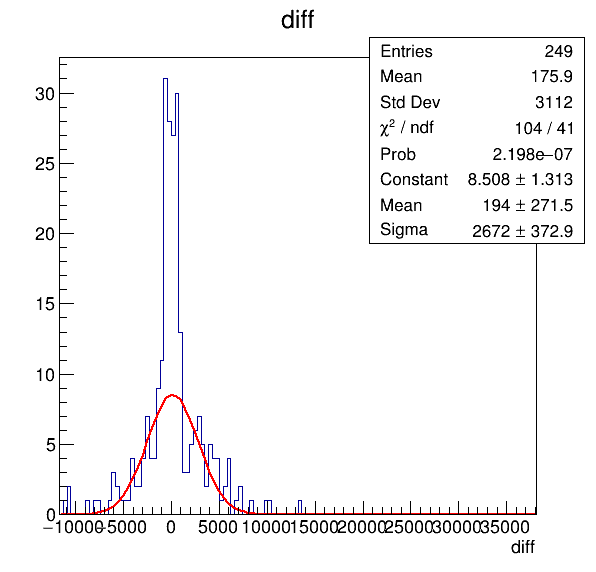

In [84]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
ROOT.gStyle.SetOptFit(1111)

binwidth = 2000
nbins = 10
data = {k: np.zeros(nbins) for k in ['Energy', 'EnergyRes', 'EnergyResErr']}
for i in range(nbins):
    d2 = d.Filter(f"z_test > {binwidth*i} && z_test < {binwidth*(i+1)}")
    if d2.Count().GetValue() < 200:
        break
    
    d2 = d2.Define("diff", "z_pred-z_test")
    h = d2.Histo1D("diff")
    h.DrawCopy()
    r = h.Fit("gaus", "S")
    data['Energy'][i] = (i+0.5)*binwidth*1e-3
    data['EnergyRes'][i] = r.Parameter(2)/((i+0.5)*binwidth+r.Parameter(1))
    data['EnergyResErr'][i] = data['EnergyRes'][i]*(r.ParError(1)/r.Parameter(1)+r.ParError(2)/r.Parameter(2))
c1.Draw()

 FCN=1.65303 FROM MIGRAD    STATUS=CONVERGED      34 CALLS          35 TOTAL
                     EDM=6.28276e-23    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.56298e-01   5.22502e-02   1.14348e-05  -7.76730e-10
   2  p1          -5.44663e-02   3.40593e-02   7.45380e-06  -1.11710e-09


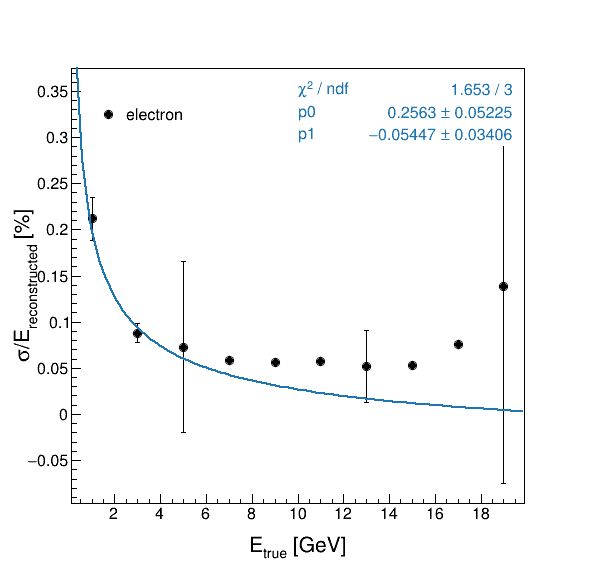

In [85]:
from tableauColors import palette


ROOT.gStyle.SetOptStat("emr")
ROOT.gStyle.SetOptFit(1)

c2 = ROOT.TCanvas("c2", "c2", 600, 600)
c2.SetLeftMargin(.12)
c2.SetBottomMargin(.12)
c2.SetRightMargin(.12)
c2.SetTopMargin(.12)

mg = ROOT.TMultiGraph()
gr = [None, None]
f1 = [None, None]
f1[0] = ROOT.TF1("f1","[0]/sqrt(x)+[1]")
f1[1] = f1[0].Clone()
f1[0].SetLineColor(palette['blue'].GetNumber())
f1[1].SetLineColor(palette['red'].GetNumber())
marker = [ROOT.kFullDotLarge, ROOT.kFullTriangleUp]

i = 0
# for i,s in enumerate(['e', 'pi']):
x = array('f', data['Energy'])
n = len(x)
y = array('f', data['EnergyRes'])
ex = array('f', [0.]*n)
ey = array('f', data['EnergyResErr'])
gr = ROOT.TGraphErrors(n, x, y, ex, ey)
gr.Fit(f1[i], "S")
gr.SetMarkerStyle(marker[i])

mg.Add(gr)
mg.Draw('ap')

c2.Update()

labelsize = 0.03
titlesize = 0.04
titleoffset = 1.2
labeloffset = 0.005
linewidth = 3
ticklength = 0.02

mg.GetXaxis().SetTitle("E_{true} [GeV]")
mg.GetYaxis().SetTitle("#sigma/E_{reconstructed} [%]")
# mg.SetMinimum(0.)
# mg.SetMaximum(16.)
mg.GetXaxis().SetTickLength(ticklength)
mg.GetYaxis().SetTickLength(ticklength)
mg.GetXaxis().SetTitleSize(titlesize)
mg.GetYaxis().SetTitleSize(titlesize)
mg.GetXaxis().SetLabelSize(labelsize)
mg.GetYaxis().SetLabelSize(labelsize)
mg.GetXaxis().CenterTitle()
mg.GetYaxis().CenterTitle()
mg.GetXaxis().SetTitleOffset(titleoffset)
mg.GetYaxis().SetTitleOffset(titleoffset)
mg.GetXaxis().SetLabelOffset(labeloffset)
mg.GetYaxis().SetLabelOffset(labeloffset)

stats1 = gr.GetListOfFunctions().FindObject("stats")
# stats2 = gr[1].GetListOfFunctions().FindObject("stats")
stats1.SetTextColor(palette['blue'].GetNumber())
# stats2.SetTextColor(palette['red'].GetNumber())
stats1.SetX2NDC(1-c2.GetRightMargin()); stats1.SetX1NDC(stats1.GetX2NDC()-0.4)
stats1.SetY2NDC(1-c2.GetTopMargin()-0.016); stats1.SetY1NDC(stats1.GetY2NDC()-0.12)
# stats2.SetX2NDC(stats1.GetX2NDC()); stats2.SetX1NDC(stats1.GetX1NDC())
# stats2.SetY2NDC(stats1.GetY1NDC()); stats2.SetY1NDC(stats2.GetY2NDC()-0.12)
stats1.SetTextSize(labelsize)
# stats2.SetTextSize(labelsize)
stats1.SetBorderSize(0)
# stats2.SetBorderSize(0)

# add legend
x1 = c2.GetLeftMargin() + 0.03
x2 = x1 + 0.25
y2 = 1 - c2.GetTopMargin() - 0.03 - 0.01
y1 = y2 - 0.08
legend = ROOT.TLegend(x1, y1, x2, y2)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(gr, "electron", "p")
# legend.AddEntry(gr[1], "pion", "p")
legend.Draw()

c2.Modified()
c2.Print("energyres.png")
c2.Draw()

In [71]:
z_pred, z_test

(array([24946.6309341 ,  1404.45580374,  1035.06862257, ...,
         1371.90180059,  8863.42131498,  6544.48131989]),
 array([21408.33540089,   924.50801965,  1100.24599705, ...,
         1546.25015299,  9001.60140181,  6665.59402163]))

1006


(array([  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   2.,   1.,   0.,   2.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   3.,   5.,
          2.,   4.,   2.,   1.,   7.,  18.,  61., 181., 466., 215.,  19.,
          3.,   1.,   0.,   1.,   0.,   1.]),
 array([-10009.72150301,  -9769.20929351,  -9528.69708401,  -9288.1848745 ,
         -9047.672665  ,  -8807.1604555 ,  -8566.648246  ,  -8326.1360365 ,
         -8085.62382699,  -7845.11161749,  -7604.59940799,  -7364.08719849,
         -7123.57498899,  -6883.06277948,  -6642.55056998,  -6402.03836048,
         -6161.52615098,  -5921.01394148,  -5680.50173197,  -5439.98952247,
         -5199.47731297,  -4958.96510347,  -4718.45289397,  -4477.94068446,
         -4237.42847496,  -3996.91626546,  -3756.40405596,  -3515.89184646,
         -3275.37963695,  -3034.86742745,  -2794.35521795,  -2553.84300845,
         -2313.33079895,  -2072.81858944,  -1832.3

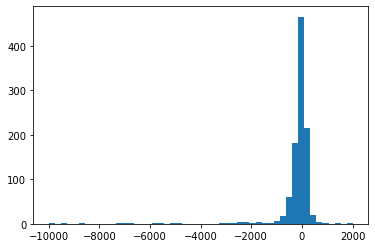

In [112]:
cond = np.bitwise_and(z_test > 1000, z_test < 2000)
z_test[cond]
print(len(z_test[cond]))
plt.hist(z_test[cond] - z_pred[cond], bins=50)

In [73]:
np.mean(np.abs(z_test - z_pred) / z_test)

0.19300961070466618

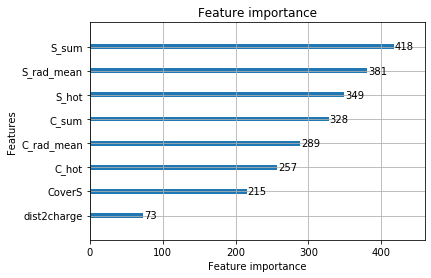

In [74]:
lgb.plot_importance(bst)

ImportError: cannot import name 'Digraph'

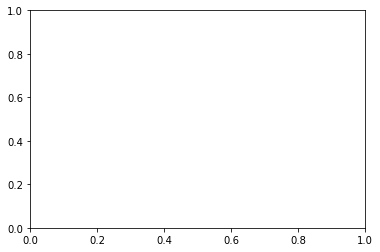

In [29]:
lgb.plot_tree(bst)

## Decay classification

In [47]:
def decayClassification(x):
    counts = x.predictedLabel.value_counts()
    mode = np.nan
    if 0 in counts.keys():
        mode = 0
    elif 1 in counts.keys():
        mode = 1
    elif 3 in counts.keys():
        mode = 2
        if 2 in counts.keys():
            if counts[2] == 2:
                mode = 3
            elif counts[2] == 4:
                mode = 4
    x['predictedPrimaryDecayMode'] = mode
    return x

In [130]:
def decayClassification(x):
    global count_nans
    counts = x.predictedLabel.value_counts()
    mode = np.nan
    if 0 in counts.keys(): # and (3 not in counts.index):
        mode = 0
    elif 1 in counts.keys(): # and (3 not in counts.index):
        mode = 1
    elif 3 in counts.keys():
        mode = 2
        if 2 in counts.keys():
            if counts[2] in [1, 2]:
                mode = 3
            elif counts[2] in [3, 4]:
                mode = 4
    elif 2 in counts.keys():
        mode = 5
    x['predictedPrimaryDecayMode'] = mode
    return x

In [131]:
df_merged2 = df_merged.groupby('eventId').apply(decayClassification)

In [132]:
df_merged2.predictedPrimaryDecayMode.isna().sum()

0

In [139]:
confusion_matrix = pd.crosstab(df_merged2.PrimaryDecayMode, 
                               df_merged2.predictedPrimaryDecayMode, 
                               rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted    0    1    2     3     4     5
Actual                                    
0          542    5    8     0     0     0
1            6  292   88     0     0     0
2           11   22  421     0     0     0
3           15  111    0  1935     0   731
4           56  211    0    45  3025  1904


In [140]:
assert np.sum(confusion_matrix.values) == df_merged2.shape[0]